# Appendix E1: Estimating Rs and Cm; a one-shot approach
**Appendix E describes Rs and Cm estimation methods**

During a patch clamp experiment, estimates of $R_s$ and $C_m$ must be made to facilitate slow capacitance and series resistance compensation.
Here we review two methods: A "one-shot" method, that uses current measured during a test pulse without $R_s$ or $C_m$ compensation to make a single prediction, and an "iterative" method, that uses currents measured during successive test pulses while $R_s$ and $C_m$ compensations are refined.

This notebook describes the one-shot approach described in Axon's pCLAMP manual, where it is attributed to Dr. Fernando Garcia-Diaz. As reference we use the pCLAMP 9 User Guide Rev D, as available from [Molecular devices](https://support.moleculardevices.com/s/article/pCLAMP-Software-Manual-Download-Page), starting on page 229.

## The set-up

A cell is attached to the pipette, the fast artefact has been cancelled out, but no $R_s$ compensation or slow transient cancellation has been applied.

A periodic step protocol is applied, consisting of repeating high ($V_{c,1}$) and low ($V_{c,2}$) steps of equal duration $T$.
Both steps are analysed identically, so we will discuss only the step at $V_c = V_{c,1}$.

We will use:
- $T = 10$ ms, based on screenshots in the pClamp manuals
- $V_1 = -60$ mV, $V_2=-70$ mv, again based on screenshots. This means a holding potential of $-70$ mV with a $10$ mV "pulse".
- A sampling rate of $25$ kHz ($\text{dt}=0.04$ ms), for 250 samples per 10ms step. This is based on the algorithm description.
- For the constants, we'll use numbers from screenshots in the manual: $R_s = 11.7 M\Omega$, $R_m = 500.3 M\Omega$, and $C_m = 31.89$ pF.

<img src="resources/rscm-2-protocol.png" style="margin:auto" />

## Simple cell-and-access model

The analysis uses the following schematic for the cell and access resistance:

<img src="resources/rscm-1-circuit.png" style="margin:auto" />

The command potential (no $V_p$ or delays etc) is applied to the series resistance $R_s$, causing a voltage drop to $V_m$.
The cell is represented by its capacitance $C_m$ and a constant membrane resistance $R_m$.
No leak or offsets are included.

The current through $R_s$ (which we'll assume is observed without error) is given by

\begin{align}
I = \frac{V_c - V_m}{R_s} = \frac{V_m}{R_m} + C_m \dot{V}_m
\end{align}

### A model for Vm

We can use these relationships to write an ODE model for $V_m$

\begin{align}
\dot{V}_m = \frac{\frac{R_m}{R_m + R_s}V_c - V_m}{\frac{R_mR_s}{R_m+R_s}C_m} = \frac{V_\infty - V_m}{\tau}
\end{align}

with analytical solution
\begin{align}
V_m(t) &= V_\infty - \left(V_\infty - V_0\right) e^{-t/\tau} \\
\end{align}

For the first step
\begin{align}
V_{\infty,1} = \frac{R_m}{R_m+R_s}V_{c,1} &&
     V_{0,1} = \frac{R_m}{R_m+R_s}V_{c,2} 
\end{align}
while for the second
\begin{align}
V_{\infty,2} = V_{0,1} &&
     V_{0,2} = V_{\infty,1}
\end{align}

We can also express these relationships in terms of a holding and a step potential:

\begin{align}
V_h &= V_{c,2} && \Delta V_c = V_{c,1} - V_{c,2}
\end{align}
allowing us to write
\begin{align}
V_m(t) = \frac{R_m}{R_m + R_s} \left[ V_h + \Delta V_c (1 - e^{-t/\tau}) \right] &&
\end{align}

### A model for I

Alternatively, we can rephrase this as a model for $I$

\begin{align}
\dot{I}_\text{Rs} = \frac{\frac{V_c}{R_s + R_m} - I}{\frac{R_sR_m}{R_s+R_m}C_m} + \frac{\dot{V}_c}{R_s}
        = \frac{I_\infty - I}{\tau} + \frac{\dot{V}_c}{R_s}
\end{align}

But now we get all the problems of a discontinuous $V_c$.
We can bypass a lot of issues by analysing only the parts of the steps where $V_c$ is constant.
In that case, we get a similar solution
\begin{align}
I(t) = I_\infty - \left(I_\infty - I_0\right) e^{-t/\tau}
\end{align}

But the constants no longer have a nice symmetry:
\begin{align}
I_{\infty,1} = \frac{1}{R_m + R_s} V_{c,1} \neq I_{0,2}
  &\quad&
I_{0,1} = \frac{V_{c,1} - V_0}{R_s}
        = \frac{V_{c,1} - \frac{R_m}{R_m+R_s}V_{c,2}}{R_s} \neq I_{\infty,2}
\end{align}

As with $V$, we will also define
\begin{align}
\Delta I = I_{\infty,1} - I_{\infty,2} = \frac{\Delta V_c}{R_m + R_s}
\end{align}

The charge carried by a current will prove quite useful, so we work out the integral of $I$ too:

\begin{align}
\int_0^T I
    &= T I_\infty - (I_\infty - I_0) \left[ -\tau e^{-T/\tau} + \tau \right] \\
    &\approx T I_\infty - (I_\infty - I_0) \tau, \quad \text{if } T \gg \tau
\end{align}

The approximation is quite a good one: for $T/\tau = 10$ we already find $e^{T/\tau}\approx 5\cdot10^{-5}$.

### Simulations

We'll now code up the V model, and run a simulation to compare with our analytical results.

In [1]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mA = myokit.parse_model('''
[[model]]
amp.Vm = -70

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rs = 11.7e-3 [GOhm] in [GOhm]
Cm = 31.89 [pF] in [pF]
Rm = 0.5003 [GOhm] in [GOhm]
Vc = 1 [mV] * engine.pace
    in [mV]
dot(Vm) = (Rm * I_obs - Vm) / (Rm * Cm)
    in [mV]
I_obs = (Vc - Vm) / Rs
    in [pA]
''')
mA.check_units(myokit.UNIT_STRICT)

# Get model constants
Rs = mA.get('amp.Rs').eval()
Rm = mA.get('amp.Rm').eval()
Cm = mA.get('amp.Cm').eval()

In [3]:
T = 10
V1 = -60
V2 = -70
dV = V1 - V2

p = myokit.Protocol()
p.schedule(start=0, level=V1, duration=T, period=2*T)
p.schedule(start=T, level=V2, duration=T, period=2*T)

In [4]:
sA = myokit.Simulation(mA, p)
sA.set_tolerance(1e-12, 1e-12)
sA.pre(2 * T)
dA = sA.run(2 * T).npview()

V0, V8, tau -68.400390625 -58.62890624999999 0.3645867849609375
V0  = -68.40 mV
Voo = -58.63 ,V
tau =  0.365 ms
I0  = 717.98 pA
Ioo = -117.2 pA


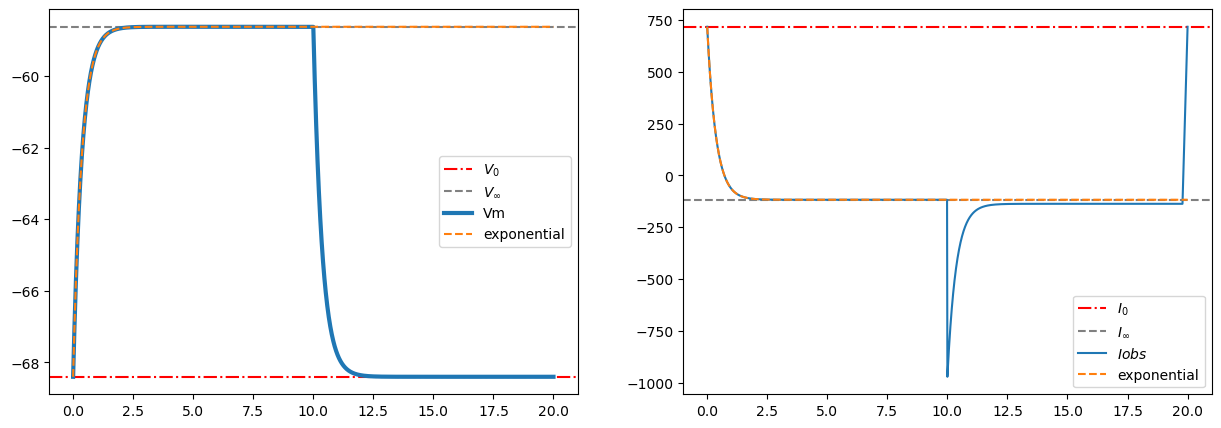

In [5]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Calculate analytical solutions for V
V0 = Rm / (Rm + Rs) * V2
V8 = Rm / (Rm + Rs) * V1
tau = (Rm * Rs) / (Rm + Rs) * Cm
print('V0, V8, tau', V0, V8, tau)
print(f'V0  = {V0:.2f} mV')
print(f'Voo = {V8:.2f} ,V')
print(f'tau = {tau:> .3f} ms')

# Show limits and exponential fit
ax1.axhline(V0, color='r', ls='-.', label='$V_0$')
ax1.axhline(V8, color='grey', ls='--', label='$V_\infty$')
ax1.plot(dA.time(), dA['amp.Vm'], lw=3, label='Vm')
ax1.plot(dA.time(), V8 - (V8 - V0) * np.exp(-dA.time() / tau), '--', label='exponential')
ax1.legend(loc='center right')

# Calculate analytical solutions for I
I0 = (V1 - Rm / (Rm + Rs) * V2) / Rs
I8 = 1 / (Rm + Rs) * V1
print(f'I0  = {I0:.2f} pA')
print(f'Ioo = {I8:.1f} pA')

# Show limits and exponential fit
ax2.axhline(I0, color='r', ls='-.', label='$I_0$')
ax2.axhline(I8, color='grey', ls='--', label='$I_\infty$')
ax2.plot(dA.time(), dA['amp.I_obs'], label='$Iobs$')
ax2.plot(dA.time(), I8 - (I8 - I0) * np.exp(-dA.time() / tau), '--', label='exponential')
ax2.legend(loc='lower right')

plt.show()

In [6]:
print(f'True Rs {1e3 * Rs:>5.1f} MOhm')
print(f'True Rm {1e3 * Rm:.1f} MOhm')
print(f'True Cm {Cm:>5.2f} pF')

True Rs  11.7 MOhm
True Rm 500.3 MOhm
True Cm 31.89 pF


## Suggested analysis

Here we'll try to recapitulate the suggested procedure, using asterisks to distinguish observed or estimated quantities from their theoretical or user-determined counterparts.

### Average the tail-ends to estimate $I_{\infty,1}$ and $I_{\infty,2}$

Estimate $I_{\infty,1}$ and $I_{\infty,2}$ as the mean observed current of the final 20% of each step.

\begin{align}
I_{\infty,1}^* &= \text{mean observed I between 0.8T and T} \\
I_{\infty,2}^* &= \text{mean observed I between 1.8T and 2T} \\
\end{align}

and use

\begin{align}
\Delta I^* = I_{\infty,1}^* - I_{\infty,2}^* 
           = \frac{V_{c,1} - V_{c,2}}{R_m^* + R_s^*}
           = \frac{\Delta V_c}{R_t^*}
\end{align}

to find an estimate of $R_t^* = R_m^* + R_s^*$.

### Fit an exponential to find $\tau^*$

A single exponential curve is fit to the observed current between 0.1T and 0.8T for step 1, and 1.1T and 1.8T for step 2.
Both should yield the same time constant $\tau^*$, for which

\begin{align}
\tau^* = \frac{R_m^*R_s^*}{R_t^*} C_m^*
\end{align}

Estimates for $I_{0,1}^*$ and $I_{0,2}^*$ can be obtained in the same step, but are not mentioned in the text.
They are probably made, however, and used to show the quality of fit.

### Integrate to find the charge used by $C_m$

Next, an estimate of the current used to charge $C_m$ is made.
To do this, we numerically find the integral of

\begin{align}
I(t) = \frac{V_m(t)}{R_m} + C_m\dot{V}_m(t)
\end{align}

and then subtract the part due to $V_m(t)/R_m$.

For the total charge carried in step 1, we can write
\begin{align}
Q_T = \int_0^T I(t)dt \approx T I_{\infty,1} - (I_{\infty,1} - I_{0,1}) \tau
\end{align}
where the approximation holds if $T$ is long enough compared to $\tau$ (and where we should really be writing e.g. $0^+$ or $T^-$ to indicate that we are not including the point with the discontinuity).

For the charge due to $V_m(t)/R_m$ we find

\begin{align}
Q_R = \frac{1}{R_m} \int_0^T V_m(t)dt
    \approx \frac{T V_{\infty,1} - (V_{\infty,1} - V_{\infty,2}) \tau}{R_m}
    = T I_{\infty,1} - (I_{\infty,1} - I_{\infty,2}) \tau
\end{align}

So that the charge needed to charge $C_m$ is given by

\begin{align}
Q_m = Q_T - Q_R = (I_{0,1} - I_{\infty,1}) \tau + \Delta I \, \tau
\end{align}

To approximate $Q_m$ we estimate the first term $Q_1 = (I_{0,1} - I_{\infty,1}) \tau$ by numerically integrating.
The second term, $Q_2 = \Delta I\,\tau$, is approximated by our estimated values $\Delta I^* \tau^*$:

\begin{align}
Q_m^* = Q_1^* + Q_2^* = Q_1^* + \Delta I^* \tau^*
\end{align}

Finally, we use the fact that, no matter how we got to this state, the charge stored in the capacitor relative to the previous step will be $C_m \Delta V_m$.
This gives us the relationship

\begin{align}
Q_m^* = Q_1^* - \Delta I^* \tau^* = \frac{R_m^*}{R_t^*} C_m^* \Delta V_c
\end{align}

### Solving

Finally, we combine $\tau = \frac{R_mR_s}{R_t}$ and $C_m^*=\frac{Q_m^*R_t^*}{R_m^*\Delta V_c}$ to find

\begin{align}
R_s^* = \frac{\tau^* \Delta V_c}{Q_m^*}
\end{align}

We can then write

\begin{align}
\Delta I^* &= I_{\infty,1}^* - I_{\infty,2}^*, \quad \text{From means}
\end{align}

\begin{align}
\tau^* &= \text{From a single exponential fit}
\end{align}

\begin{align}
Q_1^* &= \text{Area under the curve}
\end{align}

\begin{align}
Q_m^* = Q_1^* + \Delta I^* \tau^*
\end{align}

\begin{align}
R_s^* = \frac{\tau^* \Delta V_c}{Q_m^*}
\end{align}

\begin{align}
R_m^* = \frac{\Delta V_c}{\Delta I^*} - R_s^*
\end{align}

\begin{align}
C_m^* = \frac{Q_m^* (R_m^* + R_s^*)}{R_m^* \Delta V_c}
\end{align}

## Implementation

We can try this out on our model from above.

In [7]:
N = 500
dt = (2 * T) / N
print(f'Using dt={dt} for a total of {N} samples')

Using dt=0.04 for a total of 500 samples


In [8]:
sA.reset()
dA = sA.run(2 * T, log_interval=dt).npview()

Now we find points at 10% and 80% of each step.
Annoyingly, Axon always gives the protocol a little offset, which we will account for here by using slightly different percentages.

In [9]:
ipad = 15  # a 6% shift
i10 = 25 - ipad
i80 = 200 - ipad
i100 = 250 - ipad
i110, i180, i200 = 250 + i10, 250 + i80, 250 + i100

print(f't(10%) {dA.time()[i10]:>4.2f}')
print(f't(80%) {dA.time()[i80]:>4.2f}')

t(10%) 0.40
t(80%) 7.40


With these points we perform the estimates for $I_{\infty,1}$, $I_{\infty,2}$, and $dI$.

In [10]:
t, I = dA.time(), dA['amp.I_obs']
I1_est = np.mean(I[i80:i100])
I2_est = np.mean(I[i180:i200])
dI_est = I1_est - I2_est
dI = dV / (Rm + Rs)
print(f'I1* = {I1_est:.7f}, real I1 = {I8:.7f}')
print(f'I2* = {I2_est:>9.4f},    real dI = {I8 - dI:>9.4f}')
print(f'dI* = {dI_est:>9.4f},    real dI = {dI:>9.4f}')

I1* = -117.1874998, real I1 = -117.1875000
I2* = -136.7188,    real dI = -136.7188
dI* =   19.5313,    real dI =   19.5312


Next, we fit a single polynomial.
To stay true to the manual (and the 80s/90s technology?) we do this using a log-transform and manual linear least squares.

According to the algorithm section, this is performed using a lookup table.
It's likely that there's also some mechanism to avoid divide-by-zero issues.

Tau, lazy estimate 0.363
Tau, least squares 0.364
Tau, known value   0.365


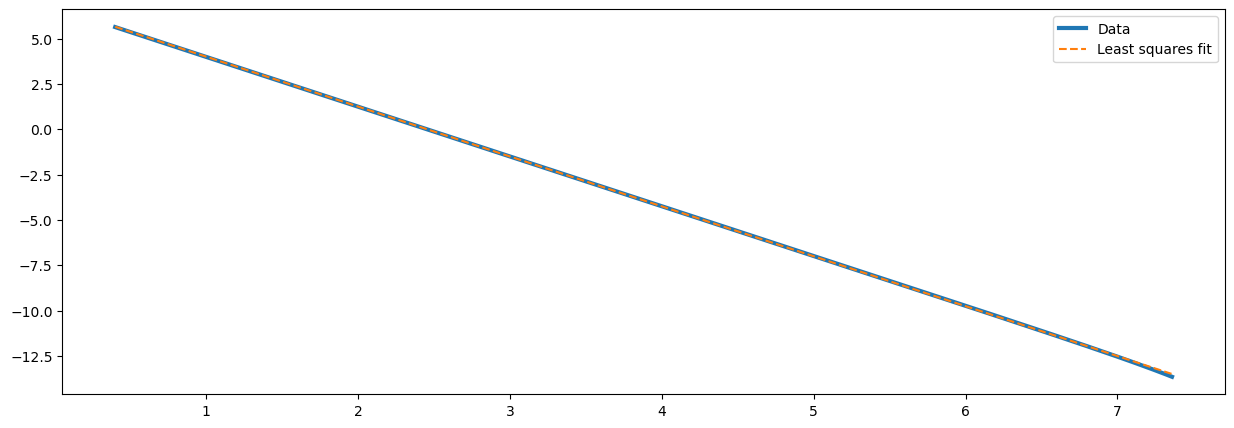

In [11]:
tlog = t[i10:i80]
ilog = np.log(I[i10:i80] - I1_est)

# From this, we can calculate a very cheap tau
tau_lazy = (0.7 * T) / (ilog[0] - ilog[-1])

# Or do a bit more work for a manual linear least squares
mx = np.mean(tlog)
my = np.mean(ilog)
rx = tlog - mx
ry = ilog - my
b = np.sum(rx * ry) / np.sum(rx ** 2)
a = my - b * mx
tau_est = -1 / b

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(tlog, ilog, lw=3, label='Data')
ax.plot(tlog, a + b * tlog, '--', label='Least squares fit')
ax.legend()

print(f'Tau, lazy estimate {tau_lazy:.3f}')
print(f'Tau, least squares {tau_est:.3f}')
print(f'Tau, known value   {tau:.3f}')

As promised, we get a bonus $I_0$ estimate:

In [12]:
I0_est = np.exp(a) + I1_est
print(f'I0, least squares {I0_est:.2f}, real {I0:.2f}')

I0, least squares 734.65, real 717.98


It's a bit off, which is to be expected when we extrapolate up an exponential, and probably the reason that we don't use this result beyond plotting.

We can now show the obtained fits

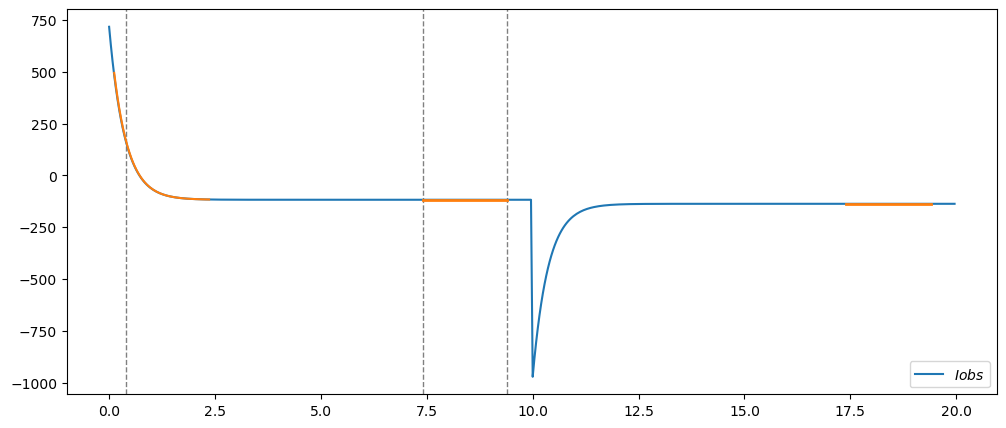

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()

dot = dict(color='grey', ls='--', lw=1)
ora = dict(color='tab:orange', lw=2)
ax.axvline(t[i10], **dot)
ax.axvline(t[i80], **dot)
ax.axvline(t[i100], **dot)
ax.plot(t, I, label='$Iobs$')
ax.plot((t[i80], t[i100]), (I1_est, I1_est), **ora)
ax.plot((t[i180], t[i200]), (I2_est, I2_est), **ora)
te = t[i10 // 3:i10 + 50]
ax.plot(te, I1_est - (I1_est - I0_est) * np.exp(-te / tau_est))

ax.legend(loc='lower right')

plt.show()

Now we integrate the positive parts of $I - I_{\infty,1}$ for step 1 to find Qm.

In [14]:
# Integrate part above I1 to find Q1
iup = I[:i80] - I1_est
iup = iup[iup > 0]
Qm_est = np.trapz(iup, dx=dt)

# And correct to find Qm, in pA * ms = fC
Qm_est += dI_est * tau_est
print(f'Estimated Qm {Qm_est:.2f} fC, real {(I0 - I8 + dI) * tau:.2f}')

Estimated Qm 311.90 fC, real 311.61


In [15]:
Rs_est = tau_est * dV / Qm_est
Rm_est = dV / dI_est - Rs_est
Cm_est = Qm_est * (Rm_est + Rs_est) / (Rm_est * dV)

print(f'Estimated Rs {1e3 * Rs_est:>5.1f} MOhm, real {1e3 * Rs:>5.1f} Mohm')
print(f'Estimated Rm {1e3 * Rm_est:>5.1f} MOhm, real {1e3 * Rm:>5.1f} MOhm')
print(f'Estimated Cm {Cm_est:>5.2f} pF,   real {Cm:>5.2f} pF')

Estimated Rs  11.7 MOhm, real  11.7 Mohm
Estimated Rm 500.3 MOhm, real 500.3 MOhm
Estimated Cm 31.92 pF,   real 31.89 pF


And there we go!

## Test on a trickier model

We can apply the same methods to a model with slightly more realistic characteristics.
We'll leave out $C_p$ and any corrections, but maintain a $V_o$ that's filtered by $R_fC_f$.

In [16]:
mB = myokit.parse_model('''
[[model]]
amp.Vm = -70
amp.Vo = -70

[engine]
time = 0 [ms] in [ms] bind time
pace = 0 bind pace

[amp]
Rm = 0.5003 [GOhm] in [GOhm]
Rs = 11.7e-3 [GOhm] in [GOhm]
Cm = 31.89 [pF] in [pF]
Rf = 0.5 [GOhm] in [GOhm]
Cf = 0.15 [pF] in [pF]
I = Vm / Rm
    in [pA]
Vc = engine.pace * 1 [mV]
    in [mV]
dot(Vm) = (Vc - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vo) = (Vc - Vm) / (Rs * Cf) - (Vo - Vc) /  (Rf * Cf)
    in [mV]
I_obs = (Vo - Vc) / Rf
    in [pA]
''')
mB.check_units(myokit.UNIT_STRICT)

In [17]:
sB = myokit.Simulation(mB, p)
sB.set_tolerance(1e-12, 1e-12)
sB.pre(2 * T)
dB = sB.run(2 * T, log_interval=dt).npview()

This model has trickier behaviour:

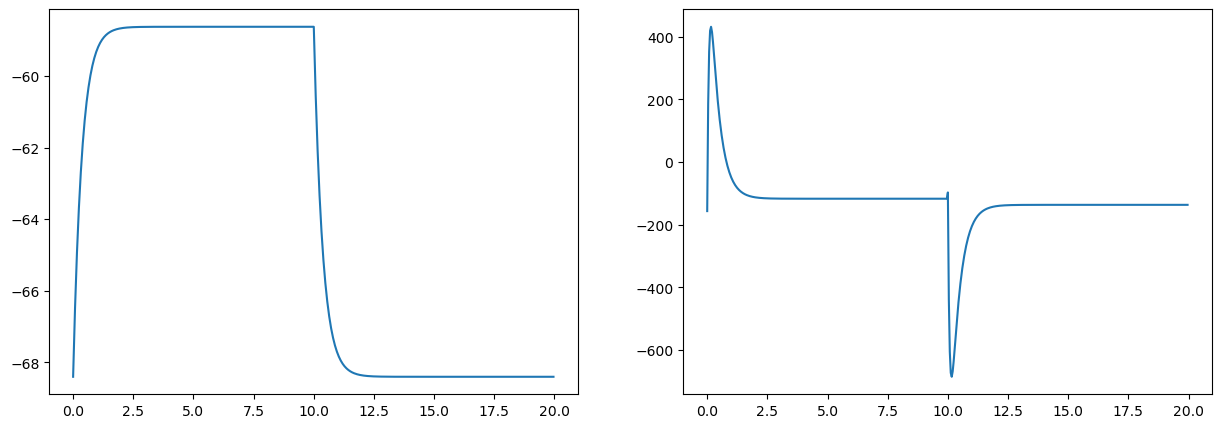

In [18]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(dB.time(), dB['amp.Vm'])
ax2.plot(dB.time(), dB['amp.I_obs'])
plt.show()

Estimate $I_{\infty,1}$, $I_{\infty,2}$, and $dI$.

In [19]:
t, I = dB.time(), dB['amp.I_obs']
I1_est = np.mean(I[i80:i100])
I2_est = np.mean(I[i180:i200])
dI_est = I1_est - I2_est
print(f'I1* = {I1_est:.7f}')
print(f'I2* = {I2_est:>9.4f}')
print(f'dI* = {dI_est:>9.4f}')

I1* = -117.1874997
I2* = -136.7188
dI* =   19.5313


Estimate $\tau$

Tau* = 0.364 ms


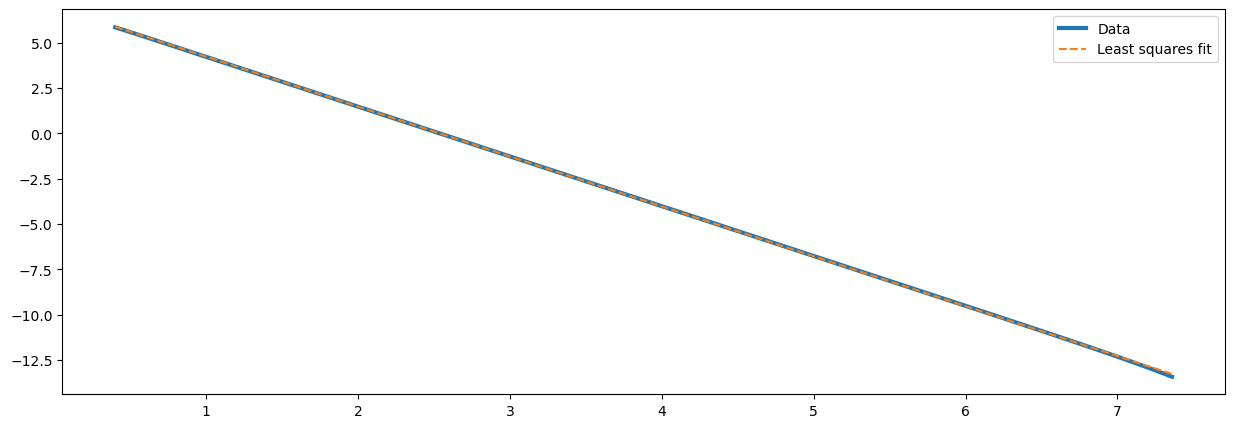

In [20]:
tlog = t[i10:i80]
ilog = np.log(I[i10:i80] - I1_est)

mx = np.mean(tlog)
my = np.mean(ilog)
rx = tlog - mx
ry = ilog - my
b = np.sum(rx * ry) / np.sum(rx ** 2)
a = my - b * mx

tau_est = -1 / b
I0_est = np.exp(a) + I1_est

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(tlog, ilog, lw=3, label='Data')
ax.plot(tlog, a + b * tlog, '--', label='Least squares fit')
ax.legend()

print(f'Tau* = {tau_est:.3f} ms')

Show the obtained fits

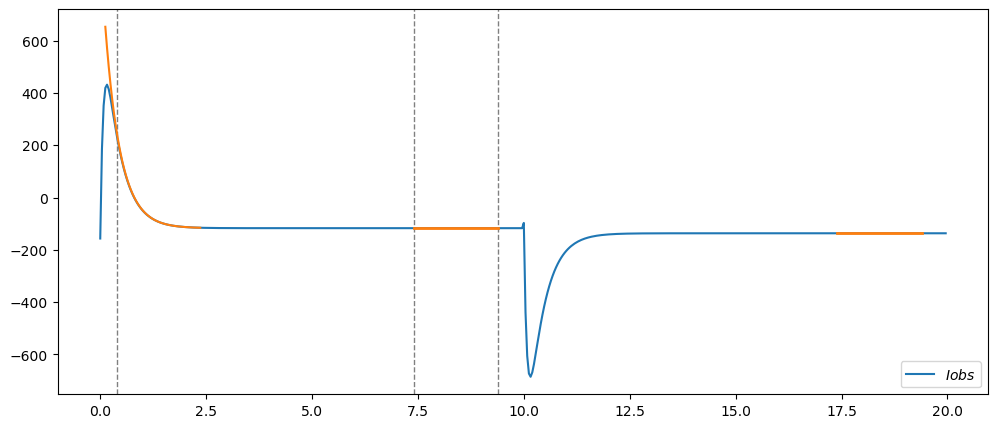

In [21]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()

dot = dict(color='grey', ls='--', lw=1)
ora = dict(color='tab:orange', lw=2)
ax.axvline(t[i10], **dot)
ax.axvline(t[i80], **dot)
ax.axvline(t[i100], **dot)
ax.plot(t, I, label='$Iobs$')
ax.plot((t[i80], t[i100]), (I1_est, I1_est), **ora)
ax.plot((t[i180], t[i200]), (I2_est, I2_est), **ora)
te = t[i10 // 3:i10 + 50]
ax.plot(te, I1_est - (I1_est - I0_est) * np.exp(-te / tau_est))

ax.legend(loc='lower right')

plt.show()

Find Qm

In [22]:
iup = I[:i80] - I1_est
iup = iup[iup > 0]
Qm_est = np.trapz(iup, dx=dt) + dI_est * tau_est
print(f'Estimated Qm {Qm_est:.2f} fC')

Estimated Qm 301.83 fC


In [23]:
Rs_est = tau_est * dV / Qm_est
Rm_est = dV / dI_est - Rs_est
Cm_est = Qm_est * (Rm_est + Rs_est) / (Rm_est * dV)

print(f'Estimated Rs {1e3 * Rs_est:>5.1f} MOhm')
print(f'Estimated Rm {1e3 * Rm_est:>5.1f} MOhm')
print(f'Estimated Cm {Cm_est:>5.2f} pF')

Estimated Rs  12.0 MOhm
Estimated Rm 500.0 MOhm
Estimated Cm 30.91 pF


So the procedure seems reasonably robust!

## One more time with noise

Now we add noise, and discover why other ways of fitting exponentials are nicer.

Tau* = 0.355 ms
I0* = 983.533 pA


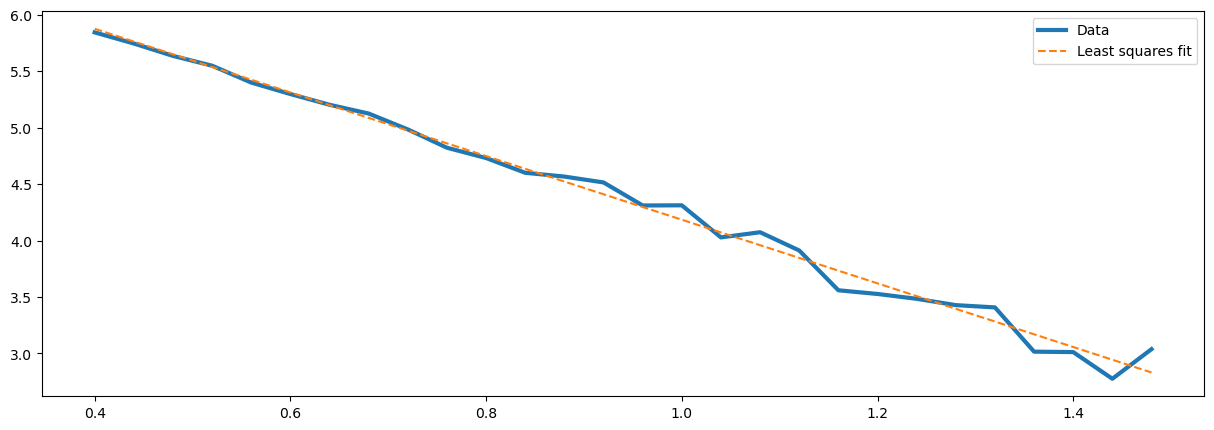

In [24]:
I = dB['amp.I_obs'] + np.random.normal(0, 5, t.shape)
I1_est = np.mean(I[i80:i100])
I2_est = np.mean(I[i180:i200])
dI_est = I1_est - I2_est

# Find points in the 10-80% range
tlog = t[i10:i80]
ilog = I[i10:i80] - I1_est
# But instead of 80%, cut-off when the data gets
# 1. too close to zero
# 2. too similar to noise to distinguish from zero
std = np.std(I[i80:i100])
istd = np.where(ilog < 2 * std)[0][0]
tlog = tlog[:istd]
ilog = ilog[:istd]
ilog = np.log(ilog)

mx = np.mean(tlog)
my = np.mean(ilog)
rx = tlog - mx
ry = ilog - my
b = np.sum(rx * ry) / np.sum(rx ** 2)
a = my - b * mx

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(tlog, ilog, lw=3, label='Data')
ax.plot(tlog, a + b * tlog, '--', label='Least squares fit')
ax.legend()

tau_est = -1 / b
I0_est = np.exp(a) + I1_est
print(f'Tau* = {tau_est:.3f} ms')
print(f'I0* = {I0_est:.3f} pA')

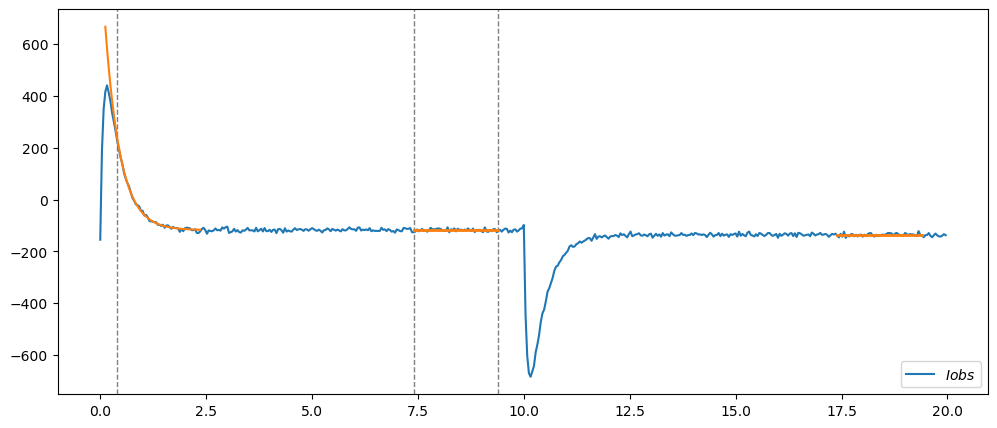

Estimated Rs  11.4 MOhm
Estimated Rm 537.2 MOhm
Estimated Cm 31.74 pF


In [25]:
iup = I[:i80] - I1_est
iup = iup[iup > 0]
Qm_est = np.trapz(iup, dx=dt) + dI_est * tau_est

Rs_est = tau_est * dV / Qm_est
Rm_est = dV / dI_est - Rs_est
Cm_est = Qm_est * (Rm_est + Rs_est) / (Rm_est * dV)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()
ax.axvline(t[i10], **dot)
ax.axvline(t[i80], **dot)
ax.axvline(t[i100], **dot)
ax.plot(t, I, label='$Iobs$')
ax.plot((t[i80], t[i100]), (I1_est, I1_est), **ora)
ax.plot((t[i180], t[i200]), (I2_est, I2_est), **ora)
te = t[i10 // 3:i10 + 50]
ax.plot(te, I1_est - (I1_est - I0_est) * np.exp(-te / tau_est))
ax.legend(loc='lower right')
plt.show()

print(f'Estimated Rs {1e3 * Rs_est:>5.1f} MOhm')
print(f'Estimated Rm {1e3 * Rm_est:>5.1f} MOhm')
print(f'Estimated Cm {Cm_est:>5.2f} pF')

So with noise, the method becomes trickier.
One strategy to remedy this is to measure the same pulse N times, and reduce the noise by averaging.

## Wrapping it up in a function

Finally, we can wrap this method up in a re-usable method.
This version has a few extra features:

1. It uses both steps (V1 and V2) to estimate two taus and two Q1s, from which it then takes an average
2. It supports irregularly sampled data.

In [32]:
from library import estimate_cell_parameters

I = dA['amp.I_obs']
Rs_est, Rm_est, Cm_est, points = estimate_cell_parameters(t, I, T, dV, dt)

print(f'Estimated Rs {1e3 * Rs_est:>5.1f} MOhm')
print(f'Estimated Rm {1e3 * Rm_est:>5.1f} MOhm')
print(f'Estimated Cm {Cm_est:>5.2f} pF')

Estimated Rs  11.7 MOhm
Estimated Rm 500.3 MOhm
Estimated Cm 31.92 pF
